# k-NN 추천시스템
Python 기반의 Surprise 패키지를 활용하여 **네이버 영화 추천시스템**을 구현합니다.<br>
네이버 영화 데이터는 '21년 3월 1일 기준 '네이버 영화'에서 최근 감상평을 등록한 사용자들의 과거 감상평을 수집한 것입니다.

In [60]:
!pip install surprise

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [61]:
import pandas as pd

In [62]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [63]:
path = '/content/drive/MyDrive/추천시스템/'
filename = '네이버 영화 평점 합본_21.03.01.csv의 사본'
df = pd.read_csv(path + '/' + filename); df

,Title,MovieID,Rating,Comment,UserID,Date
0,승리호,186342,10,재미와 감동.... 시간 가늘 줄 모르고 잘 봤습니다. 순이의 감정이 영화끝나고도 ...,hyos****,21.03.01
1,대호,127496,10,채널 돌리다가 EBS 에서 후반부 부터 본 후 여운이 깊어 오늘 늦은 시간 애들 남...,hyos****,20.12.22
2,미드나이트 스카이,199406,10,지루할정도의 차분함이 오히려.. 참 좋았다. \n\t\t\t\n\t\t\t\n\t\...,nina****,21.03.01
3,시동,183876,10,소소하지만 소소하지 않은 영화.매우만족. 별 5개 \n\t\t\t\n\t\t\t\n...,nina****,20.03.21
4,토르: 라그나로크,134898,10,밸런스가 찰떡인 영화. 토르 크리스의 인생영화. \n\t\t\t\n\t\t\t\n\...,nina****,18.05.13
...,...,...,...,...,...,...
126169,지금은맞고그때는틀리다,140199,1,첨엔 신선햇다가 지루하고영화끝나면 이영화보자고 고집해서 같이본사람에게미안해집디다그래...,jhj9****,15.09.29
126170,에베레스트,118952,1,3d 아이맥스로봣는데 돈아까웟습니다...스팩타클 긴장감따윈 개한테 줫나봅니다 \n...,jhj9****,15.09.27
126171,탐정 : 더 비기닝,124201,10,기대안햇는데 의외로 꿀잼!! \n\t\t\t\n\t\t\t\n\t\t\t\n\t\t...,jhj9****,15.09.27
126172,서부전선,125484,2,네이버평점을 절대신뢰하여 믿고봣는데낚인듯합니다. 영화시간은 또 어찌나긴지..지루하고...,jhj9****,15.09.27


In [64]:
print('고유 유저', len(set(df['UserID'])))
print('고유 영화', len(set(df['MovieID'])))

고유 유저 6669
고유 영화 12038


In [65]:
id_to_title = dict(zip(df['MovieID'], df['Title']))
title_to_id = dict(zip(df['Title'], df['MovieID']))

## 나의 영화 데이터 만들기
여러분들이 좋아하는 / 좋아하지 않는 영화 5개씩 골라서 평점을 매겨주세요.<br>
추천시스템을 구현하고 여러분들을 위한 맞춤형 영화를 추천해봅시다!

In [66]:
user_dict = {}

def my_movie_list(movie, rating):
    global user_dict
    user_dict[movie] = rating

    return user_dict

def searching_movie(movie):
    movie_df = pd.DataFrame(list(set(zip(df['Title']))), columns = ['Title'])
    movie_df = movie_df[movie_df['Title'].map(lambda x : movie in x)]

    return movie_df

In [67]:
# 영화 검색
# 키워드로 영화를 검색하고 Title을 그대로 복사해서 넣어야 합니다.
# 띄어쓰기 단위까지 일치해야 합니다.

movie = '베놈'
searching_movie(movie)

,Title
1675,베놈


In [68]:
# 본인의 영화 평점 만들기
# 10개 이상 찾아보고 평가하는 것이 좋습니다.
# 재미있었던 것뿐만 아니라 재미없었던 것도 같이 넣어주셔야 좋은 결과물이 나옵니다.

your_name = 'me'

my_movie_list('어벤져스: 엔드게임', 10)
my_movie_list('가디언즈 오브 갤럭시', 8)
my_movie_list('아이언맨 3', 10)
my_movie_list('쥬라기 월드', 7)
my_movie_list('극한직업', 6)
my_movie_list('라이온 킹', 3)
my_movie_list('트랜스포머 3', 1)
my_movie_list('군도:민란의 시대', 1)
my_movie_list('마녀', 2)
my_movie_list('베놈', 6)
my_movie_list('이터널스', 2)

{'가디언즈 오브 갤럭시': 8,
 '군도:민란의 시대': 1,
 '극한직업': 6,
 '라이온 킹': 3,
 '마녀': 2,
 '베놈': 6,
 '아이언맨 3': 10,
 '어벤져스: 엔드게임': 10,
 '이터널스': 2,
 '쥬라기 월드': 7,
 '트랜스포머 3': 1}

In [69]:
# 본인의 영화 평점을 기존 데이터프레임과 합칩니다.
# 만약 Key Error 오류가 났다면 데이터셋에 영화가 없는 것입니다. 처음부터 다시해야 합니다!

from datetime import datetime

my_movie_df = pd.DataFrame(zip(user_dict.keys(), user_dict.values()), columns = ['Title', 'Rating'])
my_movie_df['MovieID'] = my_movie_df['Title'].map(lambda x : title_to_id[x])
my_movie_df['Date'] = datetime.today().strftime('%y.%m.%d')
my_movie_df['UserID'] = your_name

df = pd.concat([df, my_movie_df])

In [70]:
df

,Title,MovieID,Rating,Comment,UserID,Date
0,승리호,186342,10,재미와 감동.... 시간 가늘 줄 모르고 잘 봤습니다. 순이의 감정이 영화끝나고도 ...,hyos****,21.03.01
1,대호,127496,10,채널 돌리다가 EBS 에서 후반부 부터 본 후 여운이 깊어 오늘 늦은 시간 애들 남...,hyos****,20.12.22
2,미드나이트 스카이,199406,10,지루할정도의 차분함이 오히려.. 참 좋았다. \n\t\t\t\n\t\t\t\n\t\...,nina****,21.03.01
3,시동,183876,10,소소하지만 소소하지 않은 영화.매우만족. 별 5개 \n\t\t\t\n\t\t\t\n...,nina****,20.03.21
4,토르: 라그나로크,134898,10,밸런스가 찰떡인 영화. 토르 크리스의 인생영화. \n\t\t\t\n\t\t\t\n\...,nina****,18.05.13
...,...,...,...,...,...,...
6,트랜스포머 3,70241,1,NaN,me,22.06.17
7,군도:민란의 시대,99752,1,NaN,me,22.06.17
8,마녀,175322,2,NaN,me,22.06.17
9,베놈,119428,6,NaN,me,22.06.17


## 데이터 전처리

In [71]:
# 평점이 7개를 초과하는 유저만 남기기

is_user_over_7 = df.groupby('UserID')['Title'].count() > 7
df = df.set_index('UserID')[is_user_over_7].reset_index(); sum(is_user_over_7)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.


2223

In [72]:
# 평점이 10개를 초과하는 영화만 남기기

is_movie_over_10 = df.groupby('MovieID')['Title'].count() > 10
df = df.set_index('MovieID')[is_movie_over_10].reset_index(); sum(is_movie_over_10)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.


2194

In [73]:
# UserID 타입 변경
df['User'] = df['UserID']
df['UserID'] = df['UserID'].astype('category')
df['UserID'] = df['UserID'].cat.codes #자동으로 숫자형 리턴 
df

,MovieID,UserID,Title,Rating,Comment,Date,User
0,129331,567,오 마이 그랜파,6,그냥저냥.. 타임킬링용 \n\t\t\t\n\t\t\t\n\t\t\t\n\t\t\t\...,21.03.01,enjo****
1,189537,567,#살아있다,1,뭐야 ! 돌려줘요 내 시간 \n\t\t\t\n\t\t\t\n\t\t\t\n\t\t\...,20.09.09,enjo****
2,107306,567,버드맨,4,글쎄. 난 잘 모르겠다. 그냥 노잼. 영화 내내 나오는 드럼 소리도 듣기 싫다. \...,20.07.05,enjo****
3,176306,567,남산의 부장들,8,역시 믿고 보는 이병헌.기대안하고 봤는데 생각보다 너무 재밌었음. \n\t\t\t\...,20.01.27,enjo****
4,182205,567,가장 보통의 연애,6,이렇게 술냄새나는 영화는 처음이네요 ;_;밤에 잠 안올때 보면 딱 좋을 영화. \n...,20.01.26,enjo****
...,...,...,...,...,...,...,...
90438,169637,1257,라이온 킹,3,NaN,22.06.17,me
90439,70241,1257,트랜스포머 3,1,NaN,22.06.17,me
90440,99752,1257,군도:민란의 시대,1,NaN,22.06.17,me
90441,175322,1257,마녀,2,NaN,22.06.17,me


In [74]:
id_to_user = dict(zip(df['UserID'], df['User']))
user_to_id = dict(zip(df['User'], df['UserID']))

In [75]:
raw_data = df[['UserID', 'MovieID', 'Rating', 'Date']] ;raw_data

,UserID,MovieID,Rating,Date
0,567,129331,6,21.03.01
1,567,189537,1,20.09.09
2,567,107306,4,20.07.05
3,567,176306,8,20.01.27
4,567,182205,6,20.01.26
...,...,...,...,...
90438,1257,169637,3,22.06.17
90439,1257,70241,1,22.06.17
90440,1257,99752,1,22.06.17
90441,1257,175322,2,22.06.17


In [76]:
raw_data.to_csv(path + '/' + '네이버 영화 평점 with My info.csv', index = False, header = False)

## k-NN 추천시스템 구현
Surprise 패키지를 활용하여 k-NN 기반 추천시스템을 구현합니다.

In [77]:
# surprise 패키지를 불러옵니다.
from surprise import KNNWithMeans
from surprise import Reader
from surprise import Dataset
from surprise import accuracy
from surprise.model_selection import train_test_split

reader = Reader(line_format='user item rating timestamp', sep = ',', rating_scale=(1, 10))
data = Dataset.load_from_file(path + '/' + '네이버 영화 평점 with My info.csv', reader=reader)

In [78]:
# Train/Test 분리 
trainset, testset = train_test_split(data, test_size=0.25)

# 정확도 계산 
algo = KNNWithMeans(k = 40)
algo.fit(trainset)
predictions = algo.test(testset)
accuracy.rmse(predictions)

Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 2.3986


2.3985749423266087

In [79]:
pred_df = pd.DataFrame(predictions); pred_df

,uid,iid,r_ui,est,details
0,1536,152632,10.0,9.216829,"{'actual_k': 40, 'was_impossible': False}"
1,1308,168405,1.0,3.858912,"{'actual_k': 9, 'was_impossible': False}"
2,592,33410,10.0,7.688038,"{'actual_k': 19, 'was_impossible': False}"
3,2079,158178,5.0,5.823320,"{'actual_k': 40, 'was_impossible': False}"
4,1581,153652,3.0,5.719325,"{'actual_k': 40, 'was_impossible': False}"
...,...,...,...,...,...
22606,1157,167105,3.0,5.406216,"{'actual_k': 40, 'was_impossible': False}"
22607,38,158180,10.0,10.000000,"{'actual_k': 40, 'was_impossible': False}"
22608,19,179125,6.0,6.437754,"{'actual_k': 40, 'was_impossible': False}"
22609,1512,159862,1.0,7.728641,"{'actual_k': 15, 'was_impossible': False}"


In [80]:
pred_df.drop('details', axis = 1, inplace = True)

In [81]:
pred_df.columns = ['UserID', 'MovieID', 'Rating', 'Estimation']

In [82]:
pred_df['UserID'] = pred_df['UserID'].astype('int')
pred_df['MovieID'] = pred_df['MovieID'].astype('int')

In [83]:
df_with_pred = pd.merge(df, pred_df, how = 'outer'); df_with_pred

,MovieID,UserID,Title,Rating,Comment,Date,User,Estimation
0,129331,567,오 마이 그랜파,6,그냥저냥.. 타임킬링용 \n\t\t\t\n\t\t\t\n\t\t\t\n\t\t\t\...,21.03.01,enjo****,NaN
1,189537,567,#살아있다,1,뭐야 ! 돌려줘요 내 시간 \n\t\t\t\n\t\t\t\n\t\t\t\n\t\t\...,20.09.09,enjo****,NaN
2,107306,567,버드맨,4,글쎄. 난 잘 모르겠다. 그냥 노잼. 영화 내내 나오는 드럼 소리도 듣기 싫다. \...,20.07.05,enjo****,NaN
3,176306,567,남산의 부장들,8,역시 믿고 보는 이병헌.기대안하고 봤는데 생각보다 너무 재밌었음. \n\t\t\t\...,20.01.27,enjo****,7.021561
4,182205,567,가장 보통의 연애,6,이렇게 술냄새나는 영화는 처음이네요 ;_;밤에 잠 안올때 보면 딱 좋을 영화. \n...,20.01.26,enjo****,5.085604
...,...,...,...,...,...,...,...,...
90545,169637,1257,라이온 킹,3,NaN,22.06.17,me,NaN
90546,70241,1257,트랜스포머 3,1,NaN,22.06.17,me,NaN
90547,99752,1257,군도:민란의 시대,1,NaN,22.06.17,me,2.502405
90548,175322,1257,마녀,2,NaN,22.06.17,me,NaN


In [84]:
uid = user_to_id[your_name]
df_with_pred[df_with_pred['UserID'] == uid]

,MovieID,UserID,Title,Rating,Comment,Date,User,Estimation
90540,136900,1257,어벤져스: 엔드게임,10,NaN,22.06.17,me,5.261307
90541,97857,1257,가디언즈 오브 갤럭시,8,NaN,22.06.17,me,5.539775
90542,70254,1257,아이언맨 3,10,NaN,22.06.17,me,NaN
90543,67786,1257,쥬라기 월드,7,NaN,22.06.17,me,2.721819
90544,167651,1257,극한직업,6,NaN,22.06.17,me,NaN
90545,169637,1257,라이온 킹,3,NaN,22.06.17,me,NaN
90546,70241,1257,트랜스포머 3,1,NaN,22.06.17,me,NaN
90547,99752,1257,군도:민란의 시대,1,NaN,22.06.17,me,2.502405
90548,175322,1257,마녀,2,NaN,22.06.17,me,NaN
90549,119428,1257,베놈,6,NaN,22.06.17,me,3.208241


In [85]:
user_pred = [(iid, algo.predict(str(uid), str(iid)).est) for iid in list(set(df['MovieID']))]

In [86]:
user_pred = sorted(user_pred, key = lambda x : x[1], reverse = True)
user_pred_top100 = user_pred[:100]

In [87]:
user_df = pd.DataFrame(user_pred_top100, columns = ['MovieID', 'Est'])
user_df['Title'] = user_df['MovieID'].map(id_to_title)

In [88]:
user_df

,MovieID,Est,Title
0,30776,9.880000,쥬라기 공원 3
1,162824,9.607862,저수지 게임
2,58333,9.090992,혐오스런 마츠코의 일생
3,82924,9.027955,더 임파서블
4,26350,8.922701,해피 엔드
...,...,...,...
95,139674,7.018004,순정
96,37544,7.012903,몽상가들
97,31788,7.008701,마이너리티 리포트
98,146504,7.007447,우리들


In [89]:
n = 30 # 추천 영화 개수 지정
is_movie_over_n = df.groupby(['MovieID'])['Title'].count() > n
is_movie_over_n_index = list(set(df.set_index('MovieID')[is_movie_over_n].index))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


In [90]:
user_df[user_df['MovieID'].map(lambda x : x in is_movie_over_n_index)]

,MovieID,Est,Title
2,58333,9.090992,혐오스런 마츠코의 일생
15,44910,8.378724,김씨 표류기
31,36666,7.795954,태극기 휘날리며
39,31268,7.618437,에이 아이
43,19074,7.583262,가타카
46,136842,7.547285,빅쇼트
48,143495,7.542917,설리: 허드슨강의 기적
53,31475,7.503930,파이란
56,59075,7.410855,본 얼티메이텀
68,102272,7.224355,연평해전


In [91]:
def movie_rec(UserID, n = 10):
    uid = user_to_id[UserID]
    df_with_pred[df_with_pred['UserID'] == uid]

    global algo

    user_pred = [(iid, algo.predict(str(uid), str(iid)).est) for iid in list(set(df['MovieID']))]

    # 평점 높은순으로 정렬
    user_pred = sorted(user_pred, key = lambda x : x[1], reverse = True)
    user_pred_top100 = user_pred[:100] # 100개의 영화

    # 유저의 추천 영화 데이터프레임 생성
    user_df = pd.DataFrame(user_pred_top100, columns = ['MovieID', 'Est'])
    user_df['Title'] = user_df['MovieID'].map(id_to_title)

    # n개 이상 평가된 영화
    is_movie_over_n = df.groupby(['MovieID'])['Title'].count() > n
    is_movie_over_n_index = list(set(df.set_index('MovieID')[is_movie_over_n].index))

    result = user_df[user_df['MovieID'].map(lambda x : x in is_movie_over_n_index)]

    return result

In [92]:
movie_rec(your_name, n = 30)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


,MovieID,Est,Title
2,58333,9.090992,혐오스런 마츠코의 일생
15,44910,8.378724,김씨 표류기
31,36666,7.795954,태극기 휘날리며
39,31268,7.618437,에이 아이
43,19074,7.583262,가타카
46,136842,7.547285,빅쇼트
48,143495,7.542917,설리: 허드슨강의 기적
53,31475,7.503930,파이란
56,59075,7.410855,본 얼티메이텀
68,102272,7.224355,연평해전


## 추천시스템 모델 비교
추천시스템의 평가지표를 비교해보며 더 좋은 모델을 찾습니다.

Estimating biases using als...
RMSE: 2.3635
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 2.5641
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 2.3986
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 2.3990
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 2.3735


array([2.36354929, 2.37348792, 2.39857494, 2.39902713, 2.56412456])

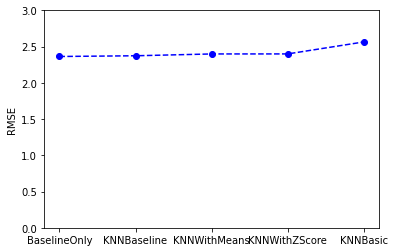

In [93]:
# 알고리즘 비교
from surprise import BaselineOnly
from surprise import KNNBasic
from surprise import KNNWithZScore
from surprise import KNNBaseline
import numpy as np

algorithms = [BaselineOnly, KNNBasic, KNNWithMeans, KNNWithZScore, KNNBaseline]
names = []
results = []
for option in algorithms:
    algo = option()
    names.append(option.__name__) # 알고리즘 이름 
    algo.fit(trainset)
    predictions = algo.test(testset)
    results.append(accuracy.rmse(predictions))
names = np.array(names)
results = np.array(results)

# 결과를 그래프로 표시
import matplotlib.pyplot as plt
index = np.argsort(results)
plt.ylim(0, 3)
plt.ylabel('RMSE')
plt.plot(names[index], results[index], 'bo--')
results[index]

In [94]:
sim_options = {'name': 'cosine', # 'pearson_baseline' / 'msd' / 'cosine'
               'user_based': False}
algo = KNNBaseline(k=30, sim_options=sim_options)
algo.fit(trainset)
predictions = algo.test(testset)
accuracy.rmse(predictions)

Estimating biases using als...
Computing the cosine similarity matrix...


/usr/local/lib/python3.7/dist-packages/surprise/prediction_algorithms/algo_base.py:249: RuntimeWarning: invalid value encountered in double_scalars
  sim = construction_func[name](*args)


Done computing similarity matrix.
RMSE: 2.3554


2.3553891714192075

## 하이퍼파라미터 튜닝
Surprise 패키지에서 제공하는 GridSearch를 통해 하이퍼파라미터를 튜닝합니다.

In [95]:
from surprise.model_selection import GridSearchCV
param_grid = {'k': [50, 60, 70],
              'sim_options': {'name': ['pearson', 'cosine'],
                              'user_based' : [True, False]}
              }
gs = GridSearchCV(KNNBaseline, param_grid, measures=['rmse'], cv=4)
gs.fit(data)

# 최적 RMSE 출력
print(gs.best_score['rmse'])

# 최적 RMSE의 parameter
print(gs.best_params['rmse'])

Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the cosine similarity matrix...


/usr/local/lib/python3.7/dist-packages/surprise/prediction_algorithms/algo_base.py:249: RuntimeWarning: invalid value encountered in double_scalars
  sim = construction_func[name](*args)


Done computing similarity matrix.
Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
E

In [96]:
algo = KNNBaseline(k = 50,
                   sim_options={'name' : 'cosine',
                                'min_support' : 1,
                                'user_based' : False})
algo.fit(trainset)
predictions = algo.test(testset)
accuracy.rmse(predictions)

Estimating biases using als...
Computing the cosine similarity matrix...


/usr/local/lib/python3.7/dist-packages/surprise/prediction_algorithms/algo_base.py:249: RuntimeWarning: invalid value encountered in double_scalars
  sim = construction_func[name](*args)


Done computing similarity matrix.
RMSE: 2.3481


2.3481402858297957

In [97]:
movie_rec(your_name, n = 20)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


,MovieID,Est,Title
10,34227,8.672327,아이 엠 샘
14,39360,8.505174,콜래트럴
15,152684,8.478869,문라이트
37,17170,7.574514,레옹
44,51708,7.297764,영웅: 샐러멘더의 비밀
59,66834,7.043947,원티드
64,87311,6.987827,장고:분노의 추적자
72,61101,6.917703,"색, 계"
73,18543,6.916729,서유기 2 - 선리기연
80,134841,6.865737,라이언
